# 2020 Workshop - Getting started with Snowflake, Python and Machine Learning
## Nic Crouch, Snowflake, March 2020

Hi there! Thanks for joining us for a Snowflake Virtual Hands on Lab workshop! 

The goal of today's workshop is to show you how to go from nothing to having a basic Machine Learning pipeline running over your data. As our example, we'll be using some datasets provided by the City of Melbourne at https://data.melbourne.vic.gov.au. 

We'll:

1) Get your Jupyter Notebook set up and connected to Snowflake

2) Set up your Snowflake instance to be ready to load up your first dataset

3) Load up the dataset, ready to start feature engineering

4) Explore the dataset to discover what feature engineering we'll have to do

5) Perform some simple feature engineering in Snowflake

6) Use part of the dataset to train Facebook Prophet, a simple machine learning library for time-series based analysis

7) Use our Prophet model to make predictions for the future, and push those predictions back into Snowflake for later use



## Step 0: Configure your environment.

### Windows Users
We're going to use a number of tools today that don't come batteries included with Python; including a couple that can be a little painful to install if you're on Windows and just using regular old Python. As such, if you're on Windows, you have three options:

1) Use a Conda environment. 

2) Use a Docker container. 

3) Use WSL.

The install of each of these is beyond the scope of the workshop; I personally recommend downloading the Anaconda distribution and using that if you don't have Docker set up already. 

This workshop was developed using the [Snowtire](https://github.com/zoharsan/snowtire) Docker image. Note that, if you're on Windows, you'll need to make sure you convert the line endings in `deploy_snowflake.sh` from Windows mode to Unix mode before building the image. You can do this in Notepad++. 

If you're using Conda, the main challenge for you will be installing Facebook Prophet / PySTAN. You'll need to follow their [instructions for Windows](https://pystan.readthedocs.io/en/latest/windows.html) in order to get it installed.

If you're using WSL, you should just be able to pretend that you're on Linux! If you've got it installed and running, the hard part is done. 

### Linux / MacOS Users

This is way easier. Just make sure you're using a virtualenv or similar. I still recommend using the [Snowtire](https://github.com/zoharsan/snowtire) image though if that's easier for you.

The following lines ensure that everything we need is installed.

### Everyone

Note that you will need approximately 4GB of RAM available to run this Notebook or the kernel will crash when you attempt to run the prediction. You'll also benefit from having more cores available.

Note that neither of these is supplied well by Docker by default. It's highly recommended to go to your Docker settings and set the resources to a more appropriate number _before_ running through this notebook.

In [1]:
import os

# This block installs things with Conda, which is recommended method by the PyStan folks for getting a
# Windows install working. Of course, it would also work on Linux if you have Conda, but so will pip.
if os == 'nt':
    !conda install libpython m2w64-toolchain -c msys2
    !conda install numpy cython -c conda-forge
    !conda install matplotlib scipy pandas -c conda-forge
!pip install ipython-sql
!pip install snowflake-connector-python[pandas]
!pip install --upgrade snowflake-sqlalchemy
!pip install pystan
!pip install fbprophet


zsh:1: no matches found: snowflake-connector-python[pandas]
  Using cached snowflake_sqlalchemy-1.2.4-py2.py3-none-any.whl (29 kB)


  Attempting uninstall: snowflake-sqlalchemy
    Found existing installation: snowflake-sqlalchemy 1.2.3
    Uninstalling snowflake-sqlalchemy-1.2.3:
      Successfully uninstalled snowflake-sqlalchemy-1.2.3


## Step 1: Connect to Snowflake

If you haven't already got one, you'll need to sign up for a free trial account at https://trial.snowflake.com. For best results *on this workshop*, I recommend using an AWS AP-Southeast-2 based account running the Enterprise edition. Soon afterwards, you'll get an email from Snowflake with the activation link you need to finish setting up your user.

Once you've got that, fill in the code block below with your account details (it's prefilled with my demo account), including the details of the user that you set up as part of the activation process. Note that we'll use `getpass` to get a plain old password in this case, but Snowflake generally recommends setting up OAuth or SSO based authentication methods in production environments.

Note: if you type in your password wrong, you can either restart the kernel using the button above, or create a new cell underneath this one and run `password = getpass.getpass()` in it. 

Note 2: If you leave this notebook open long enough, your session token might expire. In that case, just run this cell again to get a refreshed connection.

In [2]:
import getpass
import snowflake
import pandas as pd
%load_ext sql

user = 'john'
account = 'au_demo32'
region = 'ap-southeast-2'
try:
    password
except NameError:
    password = getpass.getpass()

# Don't print this on stream!
connection_string = 'snowflake://{user}:{password}@{account}.{region}'.format(user=user, password=password, account=account, region=region)

# This next line sets up IPython SQL, so that we can write direct SQL into Jupyter cells
%sql $connection_string

connection = snowflake.connector.connect(
account='{}.{}'.format(account, region),
user=user,
password=password,
role='SYSADMIN',
database='mcc_open_data',
warehouse='parking_wh',
schema='parking_sensors'
)

%sql use role sysadmin;
%sql use mcc_open_data.parking_sensors;
%sql use warehouse parking_wh;


········
 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.
 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.
 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


status
Statement executed successfully.


### Step 1.1: Testing your connection

We're going to test both the Snowflake connector directly, and the IPython SQL connector (which is really just using the SQL Alchemy library under the hood).  

In [3]:
# This should just get back the time right now.
%sql SELECT current_timestamp();

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


CURRENT_TIMESTAMP()
2021-03-22 17:55:03.235000-07:00


In [4]:
# This should just get back the time right now... again.
connection.cursor().execute('SELECT current_timestamp();').fetch_pandas_all()

,CURRENT_TIMESTAMP()
0,2021-03-22 17:55:04.104000-07:00


## Step 2: Set up the compute and the storage.

The next thing we'll do is set up a place in Snowflake - a database, schema and table - to put our data, and a compute cluster, or _virtual warehouse,_ that will do the actual work of ingesting and processing data. This should be a similar structure to any other relational database you've used previously.

Remember: In Snowflake, Compute and Storage are completely separated, so you don't need to have _any_ compute turned on to keep storing data that you've already ingested. Not only that but because of Snowflake's multi-cluster shared-compute architecture, you can have as many or as few virtual warehouses as you like, all accessing the same data with no contention.


### 2.1 Create your database and schema
Note that we're using `create or replace` here - you shouldn't re-run this cell later!
But, if you do, Snowflake gives you the ability to `UNDROP` databases and schema. Just take a look at the bottom of this notebook. 

In [5]:
%%sql 
-- This is called 'cell magic', and using ipython-sql, it makes the whole cell a SQL command.
-- ... which makes these comments (-- is comment in SQL), even though Jupyter highlights them like Python.
create or replace database mcc_open_data; 
create or replace schema parking_sensors;

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.
1 rows affected.


status
Schema PARKING_SENSORS successfully created.


### 2.2 Create the table to hold the data.
Now we're going to create the table that holds our data. The dataset we're using right now is a log of sensor readings from parking sensors all over Melbourne - they describe the arrival time and the departure time of cars, where the sensor is, and whether the car was in violation of the signed parking period or not. We're going to use this data to create a model that tells us the best times to park in parts of Melbourne.

Note that beyond the column definition, there's no additional work here - Snowflake takes care of all the optimisations that we'll need behind the scenes. 

In [6]:
%%sql
create or replace table historic_data 
    (DeviceID integer,
    ArrivalTime timestamp,
    DepartureTime timestamp,
    Duration integer,
    StreetMarker string,
    Sign string,
    Area string,
    StreetId integer,
    StreetName string,
    BetweenStreet1 string,
    BetweenStreet2 string,
    Side integer,
    InViolation boolean,
    VehiclePresent boolean
    );


 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


status
Table HISTORIC_DATA successfully created.


### 2.3 Create a warehouse to contain your compute
A _virtual warehouse_ in Snowflake is just the _logical definition_ of a compute cluster (or clusters) that you'll use to actually load and query data in Snowflake. It defines the size of the cluster, how many clusters should be used, and when the cluster will be automatically turned off, or suspended. 

When suspended, there's no actual compute associated with the cluster, so you don't pay anything for it. You only pay for the cluster when it's turned back on, which in most cases will happen within milliseconds.

Not only that, but you can increase and decrease the size of a warehouse essentially instantly, so when you have an extra heavy query, you can scale that warehouse up. Once that query is done, you can scale it back down again (or suspend it!). This lets you both control the cost of your queries _and_ get the benefit of elastically scaling cloud compute.

We won't really do this in this workshop, but one of the key features of the Warehouse architecture is that you can have essentially unlimited warehouses, allowing you to separate all of your workloads to completely separate compute - without breaking the bank.

In [7]:
%sql CREATE OR REPLACE WAREHOUSE parking_wh WAREHOUSE_SIZE='large' AUTO_SUSPEND=60 INITIALLY_SUSPENDED=TRUE;

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


status
Warehouse PARKING_WH successfully created.


## Step 3: Loading the data
There are four steps to loading structured data into Snowflake:

1) Create a table for the data to go in (already done!),

2) Tell Snowflake what format the data is in using a `FILE FORMAT`, if it's not in a basic CSV,

3) Tell Snowflake where the data is using either an _internal stage_ (storage managed by Snowflake) or an _external stage_ (storage managed in a cloud provider),

4) Load the data with `COPY INTO`.

For now, we'll use an External Stage on AWS, and CSVs derived from the CSVs hosted on the Melbourne City Council Open Data portal. 


### 3.1 Creating the File Format
Snowflake uses `FILE FORMAT`s to define how to load files - in this case, all we need to do is define the timestamp format (which is, strangely for an Australian dataset, MM/DD/YYYY). 

In [8]:
%%sql 
CREATE OR REPLACE FILE FORMAT parking_history_csv_pre_2018
    TYPE=CSV
    TIMESTAMP_FORMAT='MM/DD/YYYY HH12:MI:SS AM';

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


status
File format PARKING_HISTORY_CSV_PRE_2018 successfully created.


### 3.2 Creating the stage

Our External Stage is a simple S3 url. In general, you'd set up some authentication for this bucket, but this one happens to be completely public, so we don't need to worry about it. We're loading data from AWS today, but Snowflake also supports loading data from both Azure and GCP based blob stores. 

Notice that the stage definition also includes the file format, and the error handling method as well as the S3 URL. In this case, we'll skip up to 9 errors in the file before declaring that file unreadable and moving on. 

In [9]:
%%sql 
CREATE OR REPLACE STAGE melbourne_cc_parking_history url='s3://melbourne-cc-parking-history' 
    FILE_FORMAT=parking_history_csv_pre_2018
    copy_options=(ON_ERROR=SKIP_FILE_9)

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


status
Stage area MELBOURNE_CC_PARKING_HISTORY successfully created.


### 3.3 Ingesting Data
Ingesting data in Snowflake is as simple as running a COPY INTO statement. The COPY INTO statement at its most simple, defines the table the data will go into, and the stage the data is coming from. Let's give it a shot!

Note: If you like, before you run the below cell, go to the Snowflake UI and check the `Warehouses` tab - all of your warehouses should be suspended. When you submit the below, you should see that warehouse turn on. After 60 seconds of being idle, it'll be suspended again and will stop being charged. 

In [10]:
%%sql
-- Takes about a minute
COPY INTO historic_data FROM @melbourne_cc_parking_history
   RETURN_FAILED_ONLY=TRUE;
    


 * snowflake://john:***@au_demo32.ap-southeast-2
152 rows affected.


file,file_count,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
-,374,LOADED,250680719,250680719,None,0,None,None,None,None
s3://melbourne-cc-parking-history/2018ad.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (19) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[19]"
s3://melbourne-cc-parking-history/2018ba.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (19) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[19]"
s3://melbourne-cc-parking-history/2019ah.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (20) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[20]"
s3://melbourne-cc-parking-history/2017aa.gz,1,PARTIALLY_LOADED,685251,685250,9,8,Numeric value 'DeviceId' is not recognized,1,1,"""HISTORIC_DATA""[""DEVICEID"":1]"
s3://melbourne-cc-parking-history/2020as.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (19) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[19]"
s3://melbourne-cc-parking-history/2019cd.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (20) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[20]"
s3://melbourne-cc-parking-history/2019by.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (20) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[20]"
s3://melbourne-cc-parking-history/2020ah.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (19) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[19]"
s3://melbourne-cc-parking-history/2019co.gz,1,LOAD_FAILED,4096,0,9,4096,"Number of columns in file (20) does not match that of the corresponding table (14), use file format option error_on_column_count_mismatch=false to ignore this error",2,1,"""HISTORIC_DATA""[20]"


### 3.3.1 Uh oh!
It looks like the dataset was changed between 2017 and 2018 - there's too many columns in the newer CSVs. But, no matter, we can include a `SELECT` query in the `COPY INTO` statement that defines which columns in the source map to which column in the target table. We can also define which files in the stage should get copied. In this case, we're only copying in the 2018 files. Then, we'll do the same for 2019, which changed slightly again.

In [10]:
%%sql 
COPY INTO historic_data FROM
(SELECT $1 as DeviceId, $2 as ArrivalTime, $3 as DepartureTime, $4 as Duration, $5 as StreetMarker,
        $7 as Sign, $8 as Area, $9 as StreetId, $10 as StreetName, $12 as BetweenStreet1, $14 as BetweenStreet2,
        $15 as SideOfStreet, $18 as InViolation, $19 as VehiclePresent
FROM @melbourne_cc_parking_history/2018)
RETURN_FAILED_ONLY=TRUE;


 * snowflake://john:***@au_demo32.ap-southeast-2
2 rows affected.


file,file_count,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
-,49,LOADED,29645061,29645061,None,0,None,None,None,None
s3://melbourne-cc-parking-history/2018aa.gz,1,PARTIALLY_LOADED,594779,594778,9,8,Numeric value 'DeviceId' is not recognized,1,1,"""HISTORIC_DATA""[""DEVICEID"":1]"


In [11]:
%%sql 
COPY INTO historic_data FROM
(SELECT $1 as DeviceId, $2 as ArrivalTime, $3 as DepartureTime, $4 as Duration, $5 as StreetMarker,
        $7 as Sign, $8 as Area, $9 as StreetId, $10 as StreetName, $12 as BetweenStreet1, $14 as BetweenStreet2,
        $15 as SideOfStreet, $19 as InViolation, $20 as VehiclePresent
FROM @melbourne_cc_parking_history/2019)
RETURN_FAILED_ONLY=TRUE;

 * snowflake://john:***@au_demo32.ap-southeast-2
2 rows affected.


file,file_count,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
-,71,LOADED,42076654,42076654,None,0,None,None,None,None
s3://melbourne-cc-parking-history/2019aa.gz,1,PARTIALLY_LOADED,596090,596089,9,8,Numeric value 'DeviceId' is not recognized,1,1,"""HISTORIC_DATA""[""DEVICEID"":1]"


### 3.4 Checking our work
If everything went to plan, these two queries should return 35,908,877 and 327,648,452 respectively.

In [12]:
%sql SELECT count(*) FROM historic_data WHERE year(ArrivalTime) = 2017;
#35,908,877

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


COUNT(*)
35908877


In [13]:
%sql SELECT count(*) FROM historic_data;
#327,648,452

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


COUNT(*)
327648452


### 3.5 Standardising the data
There's two final data quality items we want to take care of before we start to analyse our data:

1) Data after 2018 refers to duration in minutes, not in seconds. 

2) We need to make sure none of the streets are typoed, or the whole thing could go wrong!


In [14]:
%%sql
UPDATE historic_data
SET Duration = DateDiff('s',ArrivalTime,DepartureTime);

 * snowflake://john:***@au_demo32.ap-southeast-2
327648452 rows affected.


number of rows updated,number of multi-joined rows updated
327648452,0


Let's quickly check for typos - the `editdistance` function checks the Levenstein distance between two strings; a good enough method to quickly check that no street names have been accidentally mis-entered.

In [15]:
%%sql
with street_names as (SELECT BetweenStreet1 as StreetName FROM historic_data 
                      UNION SELECT BetweenStreet2 as StreetName FROM historic_data)
SELECT s1.StreetName, s2.StreetName
FROM street_names s1
    JOIN street_names s2 on editdistance(s1.StreetName, s2.StreetName)<4
     and s1.StreetName != s2.StreetName ;

 * snowflake://john:***@au_demo32.ap-southeast-2
150 rows affected.


streetname,streetname_1
GEORGE STREET,MOORE STREET
PALMER STREET,VALE STREET
PALMER STREET,POWER STREET
PALMER STREET,ALBERT STREET
PALMER STREET,SALMON STREET
VALE STREET,HAWKE STREET
VALE STREET,MILES STREET
VALE STREET,WALSH STREET
VALE STREET,CAPEL STREET
VALE STREET,WADEY STREET


## 4.0 Analysing our data
It's time to look at the data and work out what we need to do to get our data into a state fit to work with our machine learning tool.

Unfortunately, for maximum speed, we now need to drop down a level - ipython-sql doesn't let us access the method that we need on the Snowflake Python driver.

Let's take a look at a subset of the data for a single set of carparks in Docklands; but this time in Pandas.

In [16]:
connection.cursor().execute("""
select * from historic_data 
    where streetname = 'CARAVEL LANE' 
    and betweenstreet1 = 'SAINT MANGOS LANE' 
    and betweenstreet2 = 'AQUITANIA WAY' 
order by arrivaltime asc;""").fetch_pandas_all()

,DEVICEID,ARRIVALTIME,DEPARTURETIME,DURATION,STREETMARKER,SIGN,AREA,STREETID,STREETNAME,BETWEENSTREET1,BETWEENSTREET2,SIDE,INVIOLATION,VEHICLEPRESENT
0,14556,2014-05-23 00:00:00,2014-05-23 10:01:53,36113,13859S,2P DIS M-SUN 0:00-23:59 OLD,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
1,14560,2014-05-23 07:30:00,2014-05-23 11:12:02,13322,13870N,LZ 30M M-SUN 7:30-18:30,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,3,False,False
2,14553,2014-05-23 07:30:00,2014-05-23 10:20:20,10220,13853S,LZ 30M M-SUN 7:30-18:30,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
3,14559,2014-05-23 07:30:00,2014-05-23 10:10:30,9630,13868N,LZ 30M M-SUN 7:30-18:30,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,3,False,False
4,14562,2014-05-23 07:30:00,2014-05-23 10:21:51,10311,13874N,1/4P M-SUN 7:30-18:30,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,3,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913235,17687,2019-12-31 19:36:02,2019-12-31 19:37:01,59,13853S,None,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
913236,17687,2019-12-31 19:37:01,2019-12-31 19:55:26,1105,13853S,None,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,True
913237,17693,2019-12-31 20:01:33,2019-12-31 20:01:45,12,13859S,2P Disabled Only,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
913238,27283,2019-12-31 22:50:59,2019-12-31 22:51:59,60,13868N,None,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,3,False,False


## 5.0 Feature Engineering / Data Transformation

There are 'duplicates' in this data that make it hard to sum up the total number of parks at any given time - ie. some events don't represent a car entering or leaving a park. 

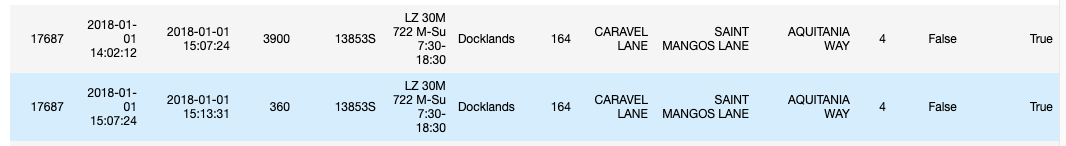

We need to collapse them so that every record represents such an event. To do this, we're going to use a QUALIFY clause - a SQL extension only present on select products, but highly useful. It will filter records out of our recordset that don't match a certain condition using a window function. 

In this case the window function is fairly simple, when you break it down. 

1. Transform VehiclePresent=False to equal 1, and VehiclePresent=True to equal 0. (This is slightly counter-intuitive, but later we're going to count up how many free spots there are).

2. If we iterate over events for a given parking space in the order that they were registered, it is clear that the average of VehiclePresent will be 0.5 between any two events where the VehiclePresent value changes. 

3. So, the `avg` function, combined with a window function, calculates exactly that:

```
    avg(CASE WHEN vehiclepresent = False THEN 1  
        WHEN vehiclepresent = True THEN 0
        END) 
    over 
        (partition by streetmarker 
         order by arrivaltime asc 
         rows between 1 preceding and 0 following)
```     
        
4. The `QUALIFY` clause then filters out any records where there wasn't a change. 


Note: we're making a key assumption here. The first is that the Departure Time for an event always corresponds to the Arrival Time for the next event. This is _generally_ true, but isn't the case at the end of each year, as MCC cut off any events that go over the New Year. Don't use this to predict parking availability on New Years Eve - take a tram!

In [17]:
#Picking on a certain year/streetmarker to test
cursor = connection.cursor().execute("""
SELECT * FROM historic_data
WHERE streetmarker = '13853S'
and year(arrivaltime) = 2018
QUALIFY avg(CASE WHEN vehiclepresent = False THEN 1  
        WHEN vehiclepresent = True THEN 0
    END) over 
        (partition by streetmarker order by arrivaltime asc rows between 1 preceding and 0 following) = 0.5
    or (row_number() over (partition by streetmarker order by arrivaltime asc) = 1)
ORDER BY arrivaltime asc;""")
dataframe = cursor.fetch_pandas_all()
dataframe

,DEVICEID,ARRIVALTIME,DEPARTURETIME,DURATION,STREETMARKER,SIGN,AREA,STREETID,STREETNAME,BETWEENSTREET1,BETWEENSTREET2,SIDE,INVIOLATION,VEHICLEPRESENT
0,17687,2018-01-01 00:00:00,2018-01-01 02:03:25,7405,13853S,None,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,True
1,17687,2018-01-01 02:03:25,2018-01-01 03:18:05,4480,13853S,None,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
2,17687,2018-01-01 03:18:05,2018-01-01 03:20:00,115,13853S,None,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,True
3,17687,2018-01-01 03:20:00,2018-01-01 07:30:00,15000,13853S,None,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
4,17687,2018-01-01 08:32:16,2018-01-01 08:33:21,65,13853S,LZ 30M 722 M-Su 7:30-18:30,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11617,17687,2018-12-31 13:16:17,2018-12-31 13:48:58,1961,13853S,LZ30MINS (722) 7:30-18:30 <>,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
11618,17687,2018-12-31 13:48:58,2018-12-31 13:53:40,282,13853S,LZ30MINS (722) 7:30-18:30 <>,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,True
11619,17687,2018-12-31 13:53:40,2018-12-31 14:18:17,1477,13853S,LZ30MINS (722) 7:30-18:30 <>,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,False
11620,17687,2018-12-31 14:18:17,2018-12-31 14:41:47,1410,13853S,LZ30MINS (722) 7:30-18:30 <>,Docklands,164,CARAVEL LANE,SAINT MANGOS LANE,AQUITANIA WAY,4,False,True


In [18]:
%%sql
ALTER WAREHOUSE parking_wh SET WAREHOUSE_SIZE = Large;
CREATE OR REPLACE TRANSIENT TABLE historic_data_changes_only AS SELECT * FROM historic_data
QUALIFY avg(CASE WHEN vehiclepresent = False THEN 1  
        WHEN vehiclepresent = True THEN 0
    END) over 
        (partition by streetmarker order by arrivaltime asc rows between 1 preceding and 0 following) = 0.5
    or (row_number() over (partition by streetmarker order by arrivaltime asc) = 1)
ORDER BY arrivaltime asc;

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.
1 rows affected.


status
Table HISTORIC_DATA_CHANGES_ONLY successfully created.


Now that each record represents an event, we can go ahead and count up how many free spaces there are for any given area, in this case, by each block. This can take longer than I'd like to wait in a live workshop! 

So, we'll scale up the warehouse that we're using. It will basically instantly scale up, we'll run the query, and then the warehouse will scale back down. 

In [19]:
connection.cursor().execute("""ALTER WAREHOUSE parking_wh SET WAREHOUSE_SIZE=XXLARGE;""")
cursor = connection.cursor().execute("""
CREATE OR REPLACE TRANSIENT TABLE historic_data_freeparks_vs_total as
with parks as (
select streetmarker, arrivaltime, streetname, betweenstreet1, betweenstreet2, 1 counter, 
        CASE WHEN vehiclepresent = False THEN 0
            WHEN vehiclepresent = True THEN 1
        END as freeparks
    from historic_data_changes_only 
    qualify row_number() over (partition by streetmarker order by arrivaltime asc) = 1
union all
select streetmarker, arrivaltime, streetname, betweenstreet1, betweenstreet2, 0 counter,
    CASE WHEN vehiclepresent = False THEN 1
        WHEN vehiclepresent = True THEN -1
    END as freeparks
    from historic_data_changes_only 
)
SELECT arrivaltime, 
        streetname, betweenstreet1, betweenstreet2,
        sum(freeparks) over (partition by streetname, betweenstreet1, betweenstreet2 order by arrivaltime asc) freeparks, 
        sum(counter) over (partition by streetname, betweenstreet1, betweenstreet2 order by arrivaltime asc RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) counter
FROM parks
ORDER BY arrivaltime asc;""")
connection.cursor().execute("""ALTER WAREHOUSE parking_wh SET WAREHOUSE_SIZE=medium;""")

## 6.0 Fitting the Model
Now that we've engineered our features, we can go ahead and train our model. First, we'll pull down a dataframe in the required format for the FB Prophet library. Then, we'll fit the model over the data. 

In [22]:
cursor = connection.cursor().execute("""
SELECT arrivaltime as "ds", 
       freeparks as "y"
FROM historic_data_freeparks_vs_total
    where streetname = 'CARAVEL LANE' 
    and betweenstreet1 = 'SAINT MANGOS LANE' 
    and betweenstreet2 = 'AQUITANIA WAY' 
and year(arrivaltime) = 2017
and month(arrivaltime) > 6
ORDER BY arrivaltime asc;""")
dataframe = cursor.fetch_pandas_all()

In [23]:
from fbprophet import Prophet

m2 = Prophet().fit(dataframe)


Importing plotly failed. Interactive plots will not work.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## 7.0 Running a prediction
Let's run a prediction!
First, we create a dataframe with space for the future. Then, we predict over it. It's that easy!

In [24]:
future2 = m2.make_future_dataframe(periods=1008, freq='10min')

In [25]:
fcst = m2.predict(future2)


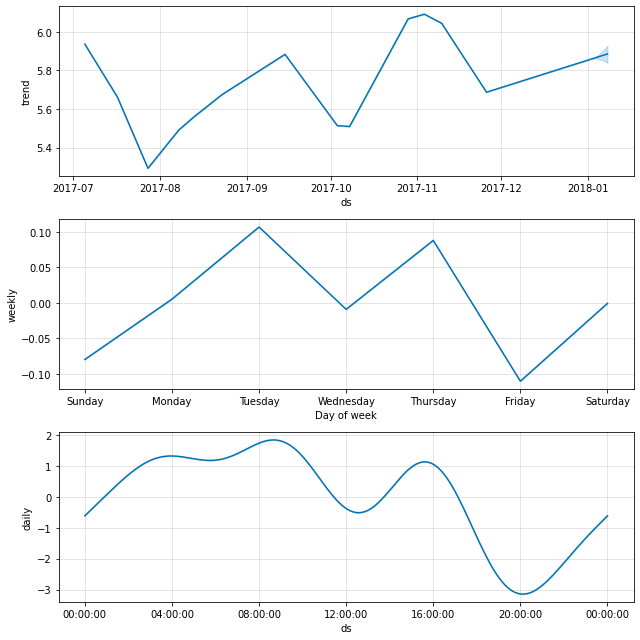

In [26]:
fig = m2.plot_components(fcst)

## 8.0 Loading back into Snowflake 


In [27]:
from sqlalchemy import create_engine
engine = create_engine(connection_string+'/mcc_open_data/parking_sensors?role=sysadmin&warehouse=parking_wh')
#engine.execute('use role sysadmin;')
#engine.execute('use mcc_open_data;')
engine.execute('use schema parking_sensors;')
#engine.execute('use warehouse parking_wh;')
table_name = 'prediction5'
fcst.to_sql(table_name, engine, if_exists='fail', index=False, chunksize=16000)

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.3.1, Python Version: 3.8.5, Platform: macOS-10.16-x86_64-i386-64bit
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.connection:closed
INFO:snowflake.connector.cursor:query: [SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [ROLLBACK]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [use schema parking_sensors;]
INFO:snowflake.connector.cursor:query execution done
INF

## Conclusion

At this stage we've very quickly used Snowflake to ingest, transform and load data to a model, before loading predictions from that model back into Snowflake (without doing the necessary evaluation of the model, which is likely extremely poor).

Now, we can use _Snowsight_ to visualise the predictions we made with that model, in the Snowflake UI. 

However, there's a number of other things we can do from here: 

1. We can load the model into a serverless computing environment, and use it as an _External Function_ in Snowflake. 
2. We can use data available on the data marketplace to augment te data we've already gathered to improve performance with a different model
3. We can use different models available in Python, such as Support Vector Machines, to generate and test better models
4. We can use SnowPipe to microbatch parking data into Snowflake from Melbourne City Council's live open data portal. 

## Miscellaneous

### Dropped/Replaced Database / Schema
Did you accidentally re-run the `create or replace` statements or accidentally drop your database/schema?
No matter! Snowflake lets you travel back in time to get them back with `UNDROP`. Here's how:

1) _Rename_ the replacement database to get it out of your way. 

2) `UNDROP` the old database. 

That's it!

In [ ]:
%%sql 

ALTER DATABASE IF EXISTS mcc_open_data RENAME TO mcc_open_data_bak;
UNDROP DATABASE mcc_open_data;



# Bonus Content


Below is content that I developed at the last minute in case we raced through the above - it loads some more data (including some JSON based weather data and pedestrian sensor data from the Melbourne CBD). We then run a Support Vector Machine over that data.

One advantage of using Snowflake is the ability to leverage multiple cloud providers - as I had to in order to load this data when AWS S3 was having issues with my network. As such, this data is all on an Azure stage, even though our accounts are in AWS.

### Step 1: Set up File Formats
Snowflake's use of File Formats is how we handle so many different file-types without needing to re-define them everytime we want to use them.

In [13]:
%%sql
CREATE OR REPLACE FILE FORMAT pedestrian_csvs 
    TYPE=CSV
    TIMESTAMP_FORMAT='MM/DD/YYYY HH12:MI:SS AM'
    DATE_FORMAT='yyyy/mm/dd'
    skip_header=1
    FIELD_OPTIONALLY_ENCLOSED_BY = '"'
    ;
    
CREATE OR REPLACE STAGE pedestrian_data 
URL= 'azure://melbournepedestrian.blob.core.windows.net/pedestrian-data'
FILE_FORMAT = pedestrian_csvs
copy_options=(ON_ERROR=SKIP_FILE_9);

CREATE OR REPLACE STAGE pedestrian_locations
URL= 'azure://melbournepedestrian.blob.core.windows.net/pedestrian-locations'
FILE_FORMAT = pedestrian_csvs
copy_options=(ON_ERROR=SKIP_FILE_9);

CREATE OR REPLACE STAGE weather_data
URL= 'azure://melbournepedestrian.blob.core.windows.net/weather-data'
FILE_FORMAT = (TYPE=JSON STRIP_OUTER_ARRAY=TRUE);
    

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


status
Stage area WEATHER_DATA successfully created.


### Step 2: Create the tables we need 

In [14]:
%%sql
CREATE OR REPLACE TABLE pedestrian_counts
(ID integer,
 Date_Time timestamp,
 Year integer,
 Month string,
 MDate integer,
 Day string,
 Time integer,
 Sensor_ID integer,
 Sensor_Name string,
 Hourly_Counts integer
 );

CREATE OR REPLACE TABLE sensor_locations
(sensor_id integer,
 sensor_description string,
 sensor_name string,
 installation_date date,
 status string,
 note string,
 direction_1 string,
 direction_2 string,
 latitude integer,
 longitude integer,
 location string
 )

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.
1 rows affected.


status
Table SENSOR_LOCATIONS successfully created.


### Step 3: Load up the data

In [15]:
%sql COPY INTO sensor_locations from @pedestrian_locations;

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
azure://melbournepedestrian.blob.core.windows.net/pedestrian-locations/Pedestrian_Counting_System_-_Sensor_Locations.csv,LOADED,69,69,9,0,None,None,None,None


In [16]:
%sql COPY INTO pedestrian_counts FROM @pedestrian_data;

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
azure://melbournepedestrian.blob.core.windows.net/pedestrian-data/Pedestrian_Counting_System_data.csv.bz2,LOADED,3302962,3302962,9,0,None,None,None,None


In [25]:
%sql SELECT * FROM pedestrian_counts where sensor_id=39 and date(date_time)='2018-12-21'

 * snowflake://john:***@au_demo32.ap-southeast-2
19 rows affected.


id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
2496872,2018-12-21 00:00:00,2018,December,21,Friday,0,39,Alfred Place,36
2496923,2018-12-21 01:00:00,2018,December,21,Friday,1,39,Alfred Place,6
2496974,2018-12-21 02:00:00,2018,December,21,Friday,2,39,Alfred Place,7
2497025,2018-12-21 03:00:00,2018,December,21,Friday,3,39,Alfred Place,11
2497076,2018-12-21 04:00:00,2018,December,21,Friday,4,39,Alfred Place,8
2497127,2018-12-21 05:00:00,2018,December,21,Friday,5,39,Alfred Place,16
2497178,2018-12-21 06:00:00,2018,December,21,Friday,6,39,Alfred Place,74
2497229,2018-12-21 07:00:00,2018,December,21,Friday,7,39,Alfred Place,254
2497280,2018-12-21 08:00:00,2018,December,21,Friday,8,39,Alfred Place,723
2497331,2018-12-21 09:00:00,2018,December,21,Friday,9,39,Alfred Place,727


### Step 4: Load up weather data. 
This is JSON data, so we use Snowflake's VARIANT column type. 

In [17]:
%sql CREATE OR REPLACE TABLE weather_data(weather variant);

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


status
Table WEATHER_DATA successfully created.


In [18]:
%sql COPY INTO weather_data FROM @weather_data;

 * snowflake://john:***@au_demo32.ap-southeast-2
1 rows affected.


file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
azure://melbournepedestrian.blob.core.windows.net/weather-data/melbourne_weather_history.json.bz2,LOADED,365328,365328,1,0,None,None,None,None


Snowflake works really well for JSON data - it's easy to ingest, and Snowflake optimises it without altering the structure:

In [19]:
%sql SELECT * FROM weather_data limit 10;

 * snowflake://john:***@au_demo32.ap-southeast-2
10 rows affected.


weather
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 0 }, ""dt"": 283996800, ""dt_iso"": ""1979-01-01 00:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 22.92, ""humidity"": 59, ""pressure"": 1008, ""temp"": 24.19, ""temp_max"": 24.9, ""temp_min"": 21.94 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""sky is clear"", ""icon"": ""01d"", ""id"": 800, ""main"": ""Clear"" } ], ""wind"": { ""deg"": 358, ""speed"": 4.47 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 0 }, ""dt"": 284000400, ""dt_iso"": ""1979-01-01 01:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 25.73, ""humidity"": 58, ""pressure"": 1008, ""temp"": 26.65, ""temp_max"": 27.77, ""temp_min"": 23.24 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""sky is clear"", ""icon"": ""01d"", ""id"": 800, ""main"": ""Clear"" } ], ""wind"": { ""deg"": 351, ""speed"": 5.12 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 1 }, ""dt"": 284004000, ""dt_iso"": ""1979-01-01 02:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 29.02, ""humidity"": 40, ""pressure"": 1007, ""temp"": 30.79, ""temp_max"": 32.98, ""temp_min"": 24.44 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""sky is clear"", ""icon"": ""01d"", ""id"": 800, ""main"": ""Clear"" } ], ""wind"": { ""deg"": 336, ""speed"": 5.16 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 10 }, ""dt"": 284007600, ""dt_iso"": ""1979-01-01 03:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 28.36, ""humidity"": 47, ""pressure"": 1007, ""temp"": 29.43, ""temp_max"": 32.06, ""temp_min"": 23.27 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""sky is clear"", ""icon"": ""01d"", ""id"": 800, ""main"": ""Clear"" } ], ""wind"": { ""deg"": 305, ""speed"": 4.88 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 25 }, ""dt"": 284011200, ""dt_iso"": ""1979-01-01 04:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 28.01, ""humidity"": 53, ""pressure"": 1006, ""temp"": 27.94, ""temp_max"": 30.9, ""temp_min"": 21.99 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""scattered clouds"", ""icon"": ""03d"", ""id"": 802, ""main"": ""Clouds"" } ], ""wind"": { ""deg"": 249, ""speed"": 3.57 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 39 }, ""dt"": 284014800, ""dt_iso"": ""1979-01-01 05:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 23.81, ""humidity"": 56, ""pressure"": 1007, ""temp"": 25.84, ""temp_max"": 28.42, ""temp_min"": 21.1 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""scattered clouds"", ""icon"": ""03d"", ""id"": 802, ""main"": ""Clouds"" } ], ""wind"": { ""deg"": 206, ""speed"": 5.95 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 38 }, ""dt"": 284018400, ""dt_iso"": ""1979-01-01 06:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 20.5, ""humidity"": 54, ""pressure"": 1008, ""temp"": 23.85, ""temp_max"": 25.63, ""temp_min"": 20.57 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""scattered clouds"", ""icon"": ""03d"", ""id"": 802, ""main"": ""Clouds"" } ], ""wind"": { ""deg"": 194, ""speed"": 6.58 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 32 }, ""dt"": 284022000, ""dt_iso"": ""1979-01-01 07:00:00 +0000 UTC"", ""lat"": -37.813628, ""lon"": 144.963058, ""main"": { ""feels_like"": 20.67, ""humidity"": 54, ""pressure"": 1009, ""temp"": 23.35, ""temp_max"": 24.94, ""temp_min"": 20.26 }, ""timezone"": 39600, ""weather"": [ { ""description"": ""scattered clouds"", ""icon"": ""03d"", ""id"": 802, ""main"": ""Clouds"" } ], ""wind"": { ""deg"": 187, ""speed"": 5.4 }}"
"{ ""city_name"": ""Melbourne"", ""clouds"": { ""all"": 45 }, ""dt"": 284025600, ""dt_iso"": ""1979-01-01 08:00:00 +0000 UTC"", ""lat"": -37

It's also easy to query; see how we can get the weather temperature and description very easily within SQL. 

In [20]:
connection.cursor().execute(
    'SELECT weather:dt::timestamp, weather:main:temp, weather:weather[0]:main, weather FROM weather_data limit 10;').fetch_pandas_all()


,WEATHER:DT::TIMESTAMP,WEATHER:MAIN:TEMP,WEATHER:WEATHER[0]:MAIN,WEATHER
0,1979-01-01 00:00:00,24.19,"""Clear""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
1,1979-01-01 01:00:00,26.65,"""Clear""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
2,1979-01-01 02:00:00,30.79,"""Clear""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
3,1979-01-01 03:00:00,29.43,"""Clear""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
4,1979-01-01 04:00:00,27.94,"""Clouds""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
5,1979-01-01 05:00:00,25.84,"""Clouds""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
6,1979-01-01 06:00:00,23.85,"""Clouds""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
7,1979-01-01 07:00:00,23.35,"""Clouds""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
8,1979-01-01 08:00:00,20.91,"""Clouds""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."
9,1979-01-01 09:00:00,19.19,"""Clouds""","{\n ""city_name"": ""Melbourne"",\n ""clouds"": {\..."


Next we need to do a one-hot encoding. There are ways to do this in pure Snowflake SQL and pure Python, but they actually work really well together in this instance. First, we're going to get all the descriptions in the set with the DISTINCT clause, and put them into a Snowflake list:

In [21]:
weathers = ','.join(connection.cursor().execute("SELECT distinct weather:weather[0]:main weather FROM weather_data").fetch_pandas_all()['WEATHER']).replace('"',"'")
print(weathers)

'Clear','Clouds','Rain','Haze','Drizzle','Smoke','Mist','Thunderstorm','Dust','Squall','Snow','Fog','Tornado'


Then, we can automatically construct a query string that uses the SQL pivot to get the weather values encoded.  

In [22]:
connection.cursor().execute(
    '''
    WITH weather as 
    (SELECT weather:dt::timestamp timestamp, weather:main:temp temp, weather:weather[0]:main weather, 1 as one
    FROM weather_data)
    SELECT p.*
    FROM weather
        pivot (count(one) for weather in ({})) as p
    ORDER BY 1 
    '''.format(weathers)).fetch_pandas_all()

,TIMESTAMP,TEMP,'Clear','Clouds','Rain','Haze','Drizzle','Smoke','Mist','Thunderstorm','Dust','Squall','Snow','Fog','Tornado'
0,1979-01-01 00:00:00,24.19,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1979-01-01 01:00:00,26.65,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1979-01-01 02:00:00,30.79,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1979-01-01 03:00:00,29.43,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1979-01-01 04:00:00,27.94,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365323,2020-09-03 19:00:00,9.25,1,0,0,0,0,0,0,0,0,0,0,0,0
365324,2020-09-03 20:00:00,8.38,1,0,0,0,0,0,0,0,0,0,0,0,0
365325,2020-09-03 21:00:00,8.19,1,0,0,0,0,0,0,0,0,0,0,0,0
365326,2020-09-03 22:00:00,9.4,1,0,0,0,0,0,0,0,0,0,0,0,0


### Step 5: Combine Weather data and Pedestrian Counts

The below query combines the query we built above to one-hot encode the weather data with the pedestrian count data. We split the hours into odd/even and then average them out to reduce the total amount of data (so as to not set my macbook on fire). 

In [23]:
dataframe = connection.cursor().execute(
    '''
    WITH weather as
    (SELECT weather:dt::timestamp timestamp, weather:main:temp temp, weather:weather[0]:main weather, 1 as one
    FROM weather_data)
    , encoded_weather as (SELECT p.*
                            FROM weather 
                                pivot (count(one) for weather in ({})) as p
                            ORDER BY 1), -- this is just the query from above
    odd_hours as 
        (SELECT hourly_counts odd_counts, 
                sensor_id sensor_id_odd, 
                dateadd(hour,-1,date_time) date_time_odd FROM pedestrian_counts 
                WHERE mod(date_part(hour,date_time),2)=1) -- getting every odd hour
    SELECT (hourly_counts+odd_counts)/2 as avg_count, 
            sensor_id, 
            encoded_weather.*, 
            month(timestamp) as month, 
            date_part(dayofmonth, timestamp) as dayofmonth, 
            date_part(dayofweek,timestamp) as dayofweek, 
            hour(timestamp) as hour
    FROM pedestrian_counts  -- this will be the even hours due to the where clause
    JOIN encoded_weather on date_time=timestamp
    LEFT JOIN odd_hours on date_time=date_time_odd and sensor_id_odd=sensor_id
    WHERE year(timestamp) in(2017,2018) and mod(date_part(hour,date_time),2)=0
    ORDER BY timestamp 
    '''.format(weathers)).fetch_pandas_all()

In [24]:
dataframe

,AVG_COUNT,SENSOR_ID,TIMESTAMP,TEMP,'Clear','Clouds','Rain','Haze','Drizzle','Smoke',...,'Thunderstorm','Dust','Squall','Snow','Fog','Tornado',MONTH,DAYOFMONTH,DAYOFWEEK,HOUR
0,112.0,27,2017-01-01 00:00:00,19.87,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,354.5,8,2017-01-01 00:00:00,19.87,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,1476.0,24,2017-01-01 00:00:00,19.87,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,2465.0,28,2017-01-01 00:00:00,19.87,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,872.5,30,2017-01-01 00:00:00,19.87,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394074,425.0,26,2018-12-31 22:00:00,19.07,1,0,0,0,0,0,...,0,0,0,0,0,0,12,31,1,22
394075,3677.5,25,2018-12-31 22:00:00,19.07,1,0,0,0,0,0,...,0,0,0,0,0,0,12,31,1,22
394076,651.5,17,2018-12-31 22:00:00,19.07,1,0,0,0,0,0,...,0,0,0,0,0,0,12,31,1,22
394077,1625.0,21,2018-12-31 22:00:00,19.07,1,0,0,0,0,0,...,0,0,0,0,0,0,12,31,1,22


If we want to de-fire the local machine even further, we can use a Window function to reduce the amount down to every 6 hours, and set the sensor id to a single sensor.

In [27]:
dataframe = connection.cursor().execute(
    '''
    WITH weather as 
    (SELECT weather:dt::timestamp timestamp, weather:main:temp temp, weather:weather[0]:main weather, 1 as one
    FROM weather_data)
    , encoded_weather as (SELECT p.*
    FROM weather 
        pivot (count(one) for weather in ({})) as p
    ORDER BY 1),
    six_hourly as 
    (SELECT avg(hourly_counts) over (order by date_time rows between 6 preceding and current row) six_hourly_counts, date_time, sensor_id FROM pedestrian_counts)
    SELECT six_hourly_counts, sensor_id, encoded_weather.*, month(timestamp) as month, date_part(dayofmonth, timestamp) as dayofmonth, date_part(dayofweek,timestamp) as dayofweek, hour(timestamp) as hour
    FROM six_hourly 
    JOIN encoded_weather on date_time=timestamp
    WHERE year(timestamp) in(2017,2018) and mod(date_part(hour,date_time),6)=0 and sensor_id=39
    ORDER BY timestamp 
    '''.format(weathers)).fetch_pandas_all()

In [28]:
dataframe

,SIX_HOURLY_COUNTS,SENSOR_ID,TIMESTAMP,TEMP,'Clear','Clouds','Rain','Haze','Drizzle','Smoke',...,'Thunderstorm','Dust','Squall','Snow','Fog','Tornado',MONTH,DAYOFMONTH,DAYOFWEEK,HOUR
0,2547.142,39,2017-01-01 00:00:00,19.87,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,174.000,39,2017-01-01 06:00:00,18.47,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,6
2,837.428,39,2017-01-01 12:00:00,16.04,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,12
3,135.714,39,2017-01-01 18:00:00,13.78,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,18
4,16.142,39,2017-01-02 00:00:00,15.41,0,1,0,0,0,0,...,0,0,0,0,0,0,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,1421.428,39,2018-12-30 18:00:00,16.9,0,1,0,0,0,0,...,0,0,0,0,0,0,12,30,0,18
2391,118.285,39,2018-12-31 00:00:00,21.99,0,1,0,0,0,0,...,0,0,0,0,0,0,12,31,1,0
2392,111.142,39,2018-12-31 06:00:00,25.09,0,1,0,0,0,0,...,0,0,0,0,0,0,12,31,1,6
2393,1242.571,39,2018-12-31 12:00:00,17.82,1,0,0,0,0,0,...,0,0,0,0,0,0,12,31,1,12


Six-hourly or every second hour is probably not useful - let's keep it to one hourly data, but for one sensor.

In [29]:
dataframe = connection.cursor().execute(
    '''
    WITH weather as 
    (SELECT weather:dt::timestamp timestamp, weather:main:temp temp, weather:weather[0]:main weather, 1 as one
    FROM weather_data)
    , encoded_weather as (SELECT p.*
    FROM weather 
        pivot (count(one) for weather in ({})) as p
    ORDER BY 1)
    SELECT hourly_counts, sensor_id, encoded_weather.*, month(timestamp) as month, date_part(dayofmonth, timestamp) as dayofmonth, date_part(dayofweek,timestamp) as dayofweek, hour(timestamp) as hour
    FROM pedestrian_counts
    JOIN encoded_weather on date_time=timestamp
    WHERE year(timestamp)< 2019 and sensor_id=39
    ORDER BY timestamp 
    '''.format(weathers)).fetch_pandas_all()

Now let's pull out the values as the labels for the dataset that we're training on. We also get rid of the Timestamp as the query above splits into hour by hour. 

In [30]:

y = dataframe.pop('HOURLY_COUNTS').values
dataframe.pop('TIMESTAMP')


0       2014-08-23 00:00:00
1       2014-08-23 01:00:00
2       2014-08-23 02:00:00
3       2014-08-23 03:00:00
4       2014-08-23 04:00:00
                ...        
34679   2018-12-31 19:00:00
34680   2018-12-31 20:00:00
34681   2018-12-31 21:00:00
34682   2018-12-31 22:00:00
34683   2018-12-31 23:00:00
Name: TIMESTAMP, Length: 34684, dtype: datetime64[ns]

In [31]:
dataframe

,SENSOR_ID,TEMP,'Clear','Clouds','Rain','Haze','Drizzle','Smoke','Mist','Thunderstorm','Dust','Squall','Snow','Fog','Tornado',MONTH,DAYOFMONTH,DAYOFWEEK,HOUR
0,39,13.65,1,0,0,0,0,0,0,0,0,0,0,0,0,8,23,6,0
1,39,16.62,1,0,0,0,0,0,0,0,0,0,0,0,0,8,23,6,1
2,39,17.46,1,0,0,0,0,0,0,0,0,0,0,0,0,8,23,6,2
3,39,18,1,0,0,0,0,0,0,0,0,0,0,0,0,8,23,6,3
4,39,18.94,0,1,0,0,0,0,0,0,0,0,0,0,0,8,23,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34679,39,13.83,1,0,0,0,0,0,0,0,0,0,0,0,0,12,31,1,19
34680,39,15.07,1,0,0,0,0,0,0,0,0,0,0,0,0,12,31,1,20
34681,39,16.91,1,0,0,0,0,0,0,0,0,0,0,0,0,12,31,1,21
34682,39,19.07,1,0,0,0,0,0,0,0,0,0,0,0,0,12,31,1,22


### Step 6: ~Magic~ Machine Learning
Now we have a Pandas data frame with features, and a Series with labels, it's time to train a model. 
First, let's install SciKit Learn and Matplotlib.

In [32]:
!pip install sklearn
!pip install matplotlib

Processing /Users/ncrouch/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897/sklearn-0.0-py2.py3-none-any.whl


Now we're going to fit a Support Vector Regression model to our data. Scikit Learn has other models too, but this one seems like a good first attempt. 

In [33]:
from sklearn import svm
from matplotlib import pyplot as plt
import pickle
m = svm.SVR(kernel='linear')
m.fit(dataframe.values, y)
s = pickle.dumps(m)
with open('./model.pickle','wb') as x:
    x.write(s)
    


<AxesSubplot:xlabel='columns'>

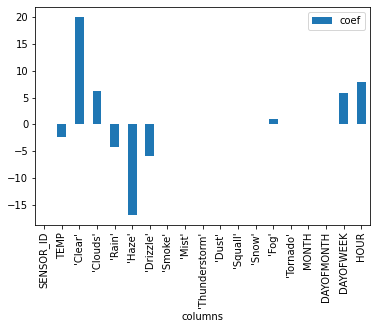

In [34]:
coef = pd.Series(m.coef_[0], name='coef')
names = pd.Series(dataframe.columns, name='columns')
pd.concat([names,coef], axis=1).plot.bar(x='columns', y='coef')

Now, let's pull a test set. We trained our data on pre-2019 - let's see how it would have worked in 2019. 

In [35]:
df_test = connection.cursor().execute(
    '''
    WITH weather as 
    (SELECT weather:dt::timestamp timestamp, weather:main:temp temp, weather:weather[0]:main weather, 1 as one
    FROM weather_data)
    , encoded_weather as (SELECT p.*
    FROM weather 
        pivot (count(one) for weather in ({})) as p
    ORDER BY 1)
    SELECT hourly_counts, sensor_id, encoded_weather.*, month(timestamp) as month, date_part(dayofmonth, timestamp) as dayofmonth, date_part(dayofweek,timestamp) as dayofweek, hour(timestamp) as hour
    FROM pedestrian_counts
    JOIN encoded_weather on date_time=timestamp
    WHERE year(timestamp) in(2019) and sensor_id=39
    ORDER BY timestamp 
    '''.format(weathers)).fetch_pandas_all()

In [36]:

y_2019 = df_test.pop('HOURLY_COUNTS').values
times = df_test.pop('TIMESTAMP')


In [37]:

preds = m.predict(df_test)
m.score(df_test.values, y_2019)


-0.15874361725328434

... not great.

In [38]:
pd_y = pd.Series(y_2019, name='ACTUAL')
pd_preds = pd.Series(preds, name='PREDICTED')
df = pd.concat([times, pd_y, pd_preds], axis=1)
#df = pd.DataFrame(data=[{'date_time':times.values, 'y':y[:, 0], 'preds':preds[:, 0]}], index=times.index)
df

,TIMESTAMP,ACTUAL,PREDICTED
0,2019-01-01 00:00:00,207,18.279245
1,2019-01-01 01:00:00,99,22.422313
2,2019-01-01 02:00:00,60,26.614169
3,2019-01-01 03:00:00,21,32.074523
4,2019-01-01 04:00:00,15,38.315491
...,...,...,...
8131,2019-12-31 19:00:00,199,182.972151
8132,2019-12-31 20:00:00,223,186.310211
8133,2019-12-31 21:00:00,158,189.819029
8134,2019-12-31 22:00:00,309,191.083582


<AxesSubplot:xlabel='TIMESTAMP'>

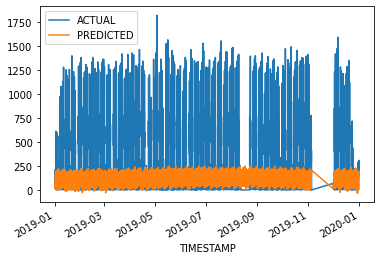

In [39]:
df.plot(x='TIMESTAMP', y=['ACTUAL','PREDICTED'])

In [53]:
df[(df['TIMESTAMP']>'2019-12-02') & (df['TIMESTAMP']<'2019-12-03')]

,TIMESTAMP,ACTUAL,PREDICTED
7417,2019-12-02 01:00:00,18,20.798603
7418,2019-12-02 02:00:00,3,34.022906
7419,2019-12-02 03:00:00,0,44.935440
7420,2019-12-02 04:00:00,3,55.617269
7421,2019-12-02 05:00:00,57,66.504415
7422,2019-12-02 06:00:00,78,77.496789
7423,2019-12-02 07:00:00,349,88.579337
7424,2019-12-02 08:00:00,850,98.479318
7425,2019-12-02 09:00:00,732,107.862000
7426,2019-12-02 10:00:00,397,116.351773
